In [10]:
"""
SVM Local Training Notebook
Optimized for local training on your machine (no Colab required)

Single Multi-Class Classification:
- 6 Gestures: idle, jump, punch, turn_left, turn_right, walk

Usage:
    1. Organize your data first: python src/organize_training_data.py
    2. Run this notebook in Jupyter or VS Code
    3. Or run as script: python notebooks/SVM_Local_Training.py
"""

('SVM Local Training Notebook\n'
 'Optimized for local training on your machine (no Colab required)\n'
 '\n'
 'Two-Stage Classification:\n'
 '1. Binary: Walking vs Not-Walking\n'
 '2. Multi-class: Jump, Punch, Turn, Idle\n'
 '\n'
 'Usage:\n'
 '    1. Organize your data first: python src/organize_training_data.py\n'
 '    2. Run this notebook in Jupyter or VS Code\n'
 '    3. Or run as script: python notebooks/SVM_Local_Training.py\n')


# SVM Local Training - Silksong Gesture Recognition

**Fast Local Training with Support Vector Machines**

This notebook trains an SVM model for gesture recognition on your local machine.
No GPU required, training takes 5-15 minutes.

## Setup Requirements:
1. ✅ Organized data in `data/organized_training/`
2. ✅ Python packages: scikit-learn, pandas, numpy, joblib

## Simplified Architecture:
- **Single Multi-Class Classifier**: 6 gestures (idle, jump, punch, turn_left, turn_right, walk)
- Parallel execution: Can run jump/punch while walking/idle

---

## 1. Configuration

In [11]:
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats
from scipy.fft import fft
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from datetime import datetime

# Configuration
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Paths (adjust if needed)
PROJECT_ROOT = Path(__file__).parent.parent if __file__ else Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data" / "organized_training"
MODEL_OUTPUT_DIR = PROJECT_ROOT / "models"
MODEL_OUTPUT_DIR.mkdir(exist_ok=True)

print(f"📂 Project root: {PROJECT_ROOT}")
print(f"📂 Data directory: {DATA_DIR}")
print(f"📂 Model output: {MODEL_OUTPUT_DIR}")
print(f"🎯 Training: Multi-class Classifier (6 gestures)")

📂 Project root: /Users/cvk/Downloads/CODELocalProjects/v3-watch_SilksongController_25TPE
📂 Data directory: /Users/cvk/Downloads/CODELocalProjects/v3-watch_SilksongController_25TPE/data/organized_training
📂 Model output: /Users/cvk/Downloads/CODELocalProjects/v3-watch_SilksongController_25TPE/models
🎯 Training mode: BOTH


## 2. Data Loading

In [12]:
def load_gesture_data(data_path, gestures):
    """
    Load all CSV files for each gesture class.
    
    Returns:
        List of (DataFrame, label, label_idx) tuples
    """
    all_data = []
    
    for gesture_idx, gesture in enumerate(gestures):
        gesture_path = data_path / gesture
        
        if not gesture_path.exists():
            print(f"⚠️  Warning: {gesture} folder not found at {gesture_path}")
            continue
        
        csv_files = list(gesture_path.glob("*.csv"))
        
        for csv_file in csv_files:
            try:
                df = pd.read_csv(csv_file)
                all_data.append((df, gesture, gesture_idx))
            except Exception as e:
                print(f"❌ Error loading {csv_file.name}: {e}")
        
        print(f"✅ Loaded {len(csv_files)} samples for '{gesture}'")
    
    return all_data

def check_metadata(data_dir):
    """Load and display metadata about organized data."""
    metadata_path = data_dir / "metadata.json"
    if metadata_path.exists():
        with open(metadata_path) as f:
            metadata = json.load(f)
        print("\n📊 Data Organization:")
        print(f"  Total files: {metadata.get('total_files_organized', 'N/A')}")
        print(f"  Multi-class: {metadata.get('multiclass_classification', {})}")
        print(f"  Noise: {metadata.get('noise_detection', {})}")
        return metadata
    else:
        print("\n⚠️  No metadata.json found")
        return None

# Check metadata
metadata = check_metadata(DATA_DIR)


📊 Data Organization:
  Total files: 228
  Binary: {'walking': 30, 'not_walking': 150}
  Multi-class: {'jump': 30, 'punch': 30, 'turn_left': 30, 'turn_right': 30, 'idle': 30}
  Noise: {'idle': 30, 'baseline': 48, 'active': 150}


## 3. Feature Engineering

In [13]:
def extract_features_from_dataframe(df):
    """
    Extract comprehensive features from sensor data.
    
    Features:
    - Time domain: mean, std, min, max, range, median, skew, kurtosis
    - Frequency domain: FFT max, dominant frequency
    - Magnitude features: accel magnitude, gyro magnitude
    
    Returns:
        dict of features
    """
    features = {}
    
    # Separate by sensor type
    accel_data = df[df['sensor'] == 'linear_acceleration']
    gyro_data = df[df['sensor'] == 'gyroscope']
    rot_data = df[df['sensor'] == 'rotation_vector']
    
    def time_features(series, prefix):
        """Extract time-domain features."""
        if len(series) == 0:
            return {}
        return {
            f'{prefix}_mean': np.mean(series),
            f'{prefix}_std': np.std(series),
            f'{prefix}_min': np.min(series),
            f'{prefix}_max': np.max(series),
            f'{prefix}_range': np.max(series) - np.min(series),
            f'{prefix}_median': np.median(series),
            f'{prefix}_skew': stats.skew(series),
            f'{prefix}_kurtosis': stats.kurtosis(series),
        }
    
    def freq_features(series, prefix):
        """Extract frequency-domain features."""
        if len(series) < 4:
            return {f'{prefix}_fft_max': 0, f'{prefix}_dom_freq': 0}
        
        fft_vals = np.abs(fft(series))
        return {
            f'{prefix}_fft_max': np.max(fft_vals[:len(fft_vals)//2]),
            f'{prefix}_dom_freq': np.argmax(fft_vals[:len(fft_vals)//2])
        }
    
    # Accelerometer features
    for axis in ['x', 'y', 'z']:
        col = f'accel_{axis}'
        if col in accel_data.columns and len(accel_data) > 0:
            series = accel_data[col].dropna()
            features.update(time_features(series, f'accel_{axis}'))
            features.update(freq_features(series, f'accel_{axis}'))
    
    # Gyroscope features
    for axis in ['x', 'y', 'z']:
        col = f'gyro_{axis}'
        if col in gyro_data.columns and len(gyro_data) > 0:
            series = gyro_data[col].dropna()
            features.update(time_features(series, f'gyro_{axis}'))
            features.update(freq_features(series, f'gyro_{axis}'))
    
    # Rotation features (quaternion)
    for axis in ['w', 'x', 'y', 'z']:
        col = f'rot_{axis}'
        if col in rot_data.columns and len(rot_data) > 0:
            series = rot_data[col].dropna()
            features.update(time_features(series, f'rot_{axis}'))
    
    # Magnitude features
    if len(accel_data) > 0 and all(f'accel_{ax}' in accel_data.columns for ax in ['x', 'y', 'z']):
        accel_mag = np.sqrt(
            accel_data['accel_x']**2 + 
            accel_data['accel_y']**2 + 
            accel_data['accel_z']**2
        )
        features.update(time_features(accel_mag, 'accel_mag'))
    
    if len(gyro_data) > 0 and all(f'gyro_{ax}' in gyro_data.columns for ax in ['x', 'y', 'z']):
        gyro_mag = np.sqrt(
            gyro_data['gyro_x']**2 + 
            gyro_data['gyro_y']**2 + 
            gyro_data['gyro_z']**2
        )
        features.update(time_features(gyro_mag, 'gyro_mag'))
    
    return features

print("✅ Feature extraction function defined")

✅ Feature extraction function defined


## 4. Train Multi-Class Classifier (6 Gestures)


STAGE 1: BINARY CLASSIFIER (Walking vs Not-Walking)

Loading binary classification data...
✅ Loaded 30 samples for 'walking'
✅ Loaded 150 samples for 'not_walking'

Extracting features...
  Processed 20/180 samples...
  Processed 40/180 samples...
  Processed 60/180 samples...
  Processed 80/180 samples...
  Processed 100/180 samples...
  Processed 120/180 samples...
  Processed 140/180 samples...
  Processed 160/180 samples...
  Processed 180/180 samples...

✅ Feature extraction complete!
   Shape: (180, 108)
   Features: 108

📊 Class distribution:
   walking: 30 samples
   not_walking: 150 samples

Train set: 144 samples
Test set: 36 samples

Training SVM (this may take 2-5 minutes)...

✅ Binary SVM training complete!
   Training accuracy: 97.22%
   Test accuracy: 91.67%

Classification Report:
              precision    recall  f1-score   support

     walking       0.80      0.67      0.73         6
 not_walking       0.94      0.97      0.95        30

    accuracy               

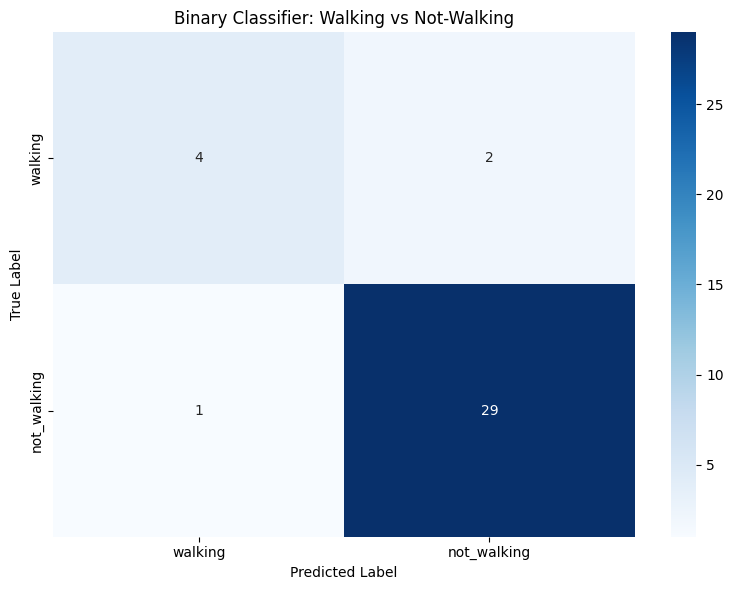


💾 Binary model saved to: /Users/cvk/Downloads/CODELocalProjects/v3-watch_SilksongController_25TPE/models/
   - gesture_classifier_binary.pkl
   - feature_scaler_binary.pkl
   - feature_names_binary.pkl


In [14]:
print("\n" + "="*60)
print("MULTI-CLASS CLASSIFIER (6 Gestures)")
print("="*60 + "\n")

# Load multiclass data
multiclass_path = DATA_DIR / "multiclass"
# FIXED: All 6 gestures including turn_left and turn_right separately
multiclass_gestures = ['idle', 'jump', 'punch', 'turn_left', 'turn_right', 'walk']

print("Loading multi-class data...")
multiclass_data = load_gesture_data(multiclass_path, multiclass_gestures)

# Extract features
print("\nExtracting features...")
X_multi_features = []
y_multi_labels = []

for i, (df, gesture, gesture_idx) in enumerate(multiclass_data):
    try:
        features = extract_features_from_dataframe(df)
        X_multi_features.append(features)
        y_multi_labels.append(gesture_idx)
        
        if (i + 1) % 20 == 0:
            print(f"  Processed {i + 1}/{len(multiclass_data)} samples...")
    except Exception as e:
        print(f"❌ Error: {e}")

# Convert to arrays
X_multi_df = pd.DataFrame(X_multi_features).fillna(0)
y_multi = np.array(y_multi_labels)

print(f"\n✅ Feature extraction complete!")
print(f"   Shape: {X_multi_df.shape}")
print(f"   Features: {len(X_multi_df.columns)}")

# Check class distribution
unique, counts = np.unique(y_multi, return_counts=True)
print(f"\n📊 Class distribution:")
for gesture_idx, count in zip(unique, counts):
    print(f"   {multiclass_gestures[gesture_idx]}: {count} samples")

# Warn about imbalance
max_count = max(counts)
min_count = min(counts)
if max_count > min_count * 1.3:
    print(f"\n⚠️  Warning: Class imbalance (ratio: {max_count/min_count:.2f}x)")
    print(f"   Consider collecting more data for minority classes")

# Split data
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi_df, y_multi,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y_multi
)

# Scale features
scaler_multi = StandardScaler()
X_train_m_scaled = scaler_multi.fit_transform(X_train_m)
X_test_m_scaled = scaler_multi.transform(X_test_m)

print(f"\nTrain set: {X_train_m.shape[0]} samples")
print(f"Test set: {X_test_m.shape[0]} samples")

# Train SVM
print("\nTraining SVM (this may take 2-5 minutes)...")
svm_multi = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=RANDOM_SEED,
    probability=True
)
svm_multi.fit(X_train_m_scaled, y_train_m)

# Evaluate
train_acc_m = svm_multi.score(X_train_m_scaled, y_train_m)
test_acc_m = svm_multi.score(X_test_m_scaled, y_test_m)

print(f"\n✅ Multi-class SVM training complete!")
print(f"   Training accuracy: {train_acc_m:.2%}")
print(f"   Test accuracy: {test_acc_m:.2%}")

# Predictions
y_pred_m = svm_multi.predict(X_test_m_scaled)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_m, y_pred_m, target_names=multiclass_gestures))

# Confusion matrix
cm_m = confusion_matrix(y_test_m, y_pred_m)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_m, annot=True, fmt='d', cmap='Blues',
            xticklabels=multiclass_gestures, yticklabels=multiclass_gestures)
plt.title('Multi-class Classifier: 6 Gestures')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(MODEL_OUTPUT_DIR / 'multiclass_confusion_matrix.png', dpi=300)
print(f"\n💾 Confusion matrix saved to: {MODEL_OUTPUT_DIR / 'multiclass_confusion_matrix.png'}")
plt.show()

# Save model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
joblib.dump(svm_multi, MODEL_OUTPUT_DIR / f"gesture_classifier_multiclass_{timestamp}.pkl")
joblib.dump(scaler_multi, MODEL_OUTPUT_DIR / f"feature_scaler_multiclass_{timestamp}.pkl")
joblib.dump(list(X_multi_df.columns), MODEL_OUTPUT_DIR / f"feature_names_multiclass_{timestamp}.pkl")

# Also save as default names
joblib.dump(svm_multi, MODEL_OUTPUT_DIR / "gesture_classifier.pkl")
joblib.dump(scaler_multi, MODEL_OUTPUT_DIR / "feature_scaler.pkl")
joblib.dump(list(X_multi_df.columns), MODEL_OUTPUT_DIR / "feature_names.pkl")

print(f"\n💾 Multi-class model saved to: {MODEL_OUTPUT_DIR}/")
print(f"   - gesture_classifier.pkl")
print(f"   - feature_scaler.pkl")
print(f"   - feature_names.pkl")

## 5. Summary

In [15]:
print("\n" + "="*60)
print("🎉 TRAINING COMPLETE!")
print("="*60)

print(f"\n📊 Multi-class Classifier (6 gestures):")
print(f"   Test Accuracy: {test_acc_m:.2%}")
print(f"   Model: models/gesture_classifier.pkl")

print(f"\n✨ Next Steps:")
print(f"   1. Test model with: python src/udp_listener.py")
print(f"   2. Models are in: {MODEL_OUTPUT_DIR}/")
print(f"   3. Controller will use single multi-class classifier")

print(f"\n💡 Parallel Controller Logic:")
print(f"   - Single classifier predicts all 6 gestures")
print(f"   - idle/walk states: Locomotion")
print(f"   - jump/punch actions: Can execute while walking or idle")
print(f"   - turn_left/turn_right: Direction changes")


STAGE 2: MULTI-CLASS CLASSIFIER (Jump, Punch, Turn, Idle)

Loading multi-class data...
✅ Loaded 30 samples for 'jump'
✅ Loaded 30 samples for 'punch'
⚠️  Warning: turn folder not found at /Users/cvk/Downloads/CODELocalProjects/v3-watch_SilksongController_25TPE/data/organized_training/multiclass_classification/turn
✅ Loaded 30 samples for 'idle'

Extracting features...
  Processed 20/90 samples...
  Processed 40/90 samples...
  Processed 60/90 samples...
  Processed 80/90 samples...

✅ Feature extraction complete!
   Shape: (90, 108)
   Features: 108

📊 Class distribution:
   jump: 30 samples
   punch: 30 samples
   turn: 30 samples

Train set: 72 samples
Test set: 18 samples

Training SVM (this may take 2-5 minutes)...

✅ Multi-class SVM training complete!
   Training accuracy: 81.94%
   Test accuracy: 72.22%

Classification Report:


ValueError: Number of classes, 3, does not match size of target_names, 4. Try specifying the labels parameter